#Homework week 04 group 40

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

##Load dataset and define size for all images

In [2]:
malaria_train, malaria_test = tfds.load("malaria", split = ['train[:90%]', 'train[90%:]'], as_supervised = True)
target_height = 40#size of largest element = 394
target_width = 40#size of largest element = 394

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteLLYWTY/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


##Inspect the input images

In [3]:
ls = []
for i in malaria_train:
    ls.append(i[0].shape)
print(np.min(ls))
np.argmax(ls)
np.min(ls, axis= 0)

3


array([40, 46,  3])

##Preprocess the dataset and input pipeline

In [4]:
def preprocess(input, label):
    input = input/255
    input = tf.image.resize_with_pad(input ,target_height, target_width)
    label = tf.one_hot(label, 2)
    return (input, label)
malaria_train = malaria_train.map(preprocess)
malaria_test = malaria_test.map(preprocess)
malaria_train =   (tf.data.Dataset.shuffle(malaria_train,buffer_size = 100000, reshuffle_each_iteration=True).batch(64)).prefetch(1)
malaria_test =   (tf.data.Dataset.shuffle(malaria_test,buffer_size = 100000, reshuffle_each_iteration=True).batch(64)).prefetch(1)

##Define the model

In [5]:
class Convmodel(tf.keras.Model):
    def __init__(self):
        # inherit information from the higher class
        super(Convmodel, self).__init__()
        
        self.target_height = 40
        self.target_width = 40
        # use 4 convolutional layers with decreasing filter size and relu activation function
        self.hidden_layer1 = tf.keras.layers.Conv2D(filters = 100, kernel_size = 3, padding = "valid", activation= "relu", input_shape = (self.target_height,self.target_width,3))
        # use pooling layers inbetween
        self.hidden_layer2 = tf.keras.layers.MaxPool2D()
        # dropout layer to prevent overfitting
        self.hidden_layer_dropout = tf.keras.layers.Dropout(rate = 0.3)
        self.hidden_layer3 = tf.keras.layers.Conv2D(filters = 60, kernel_size = 3, padding = "valid", activation= "relu")
        self.hidden_layer4 = tf.keras.layers.MaxPool2D()
        self.hidden_layer5 = tf.keras.layers.Conv2D(filters = 40, kernel_size = 3, padding = "valid", activation= "relu")
        self.hidden_layer6 = tf.keras.layers.MaxPool2D()
        self.hidden_layer7 = tf.keras.layers.Conv2D(filters = 20, kernel_size = 3, padding = "valid", activation= "relu")
        self.hidden_layer8 = tf.keras.layers.GlobalAveragePooling2D()
        # implement the output layer with 2 units and the softmax activation function
        self.output_layer = tf.keras.layers.Dense(units = 2, activation = tf.keras.activations.softmax)
    
    # define the forward step for the model
    def call(self, x, training_bool = False):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer_dropout(x, training = training_bool)
        x = self.hidden_layer3(x)
        x = self.hidden_layer4(x)
        x = self.hidden_layer5(x)
        x = self.hidden_layer6(x)
        x = self.hidden_layer7(x)
        x = self.hidden_layer8(x)
        x = self.output_layer(x)
        return x

##Define training step

In [6]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        expectation = model(input, training_bool = True)
        train_accuracy =  np.argmax(target, axis = 1) == np.argmax(expectation, axis = 1)
        loss = loss_function(target, expectation)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, train_accuracy

##Define test step

In [7]:
def test(model, test_data, loss_function):
    test_accuracies_total = []
    test_losses_total = []
    # Compute and return loss and accuracy of Test-data
    for (input, target) in test_data:
        expectation = model(input)
        test_loss = loss_function(target, expectation)
        test_accuracy =  np.argmax(target, axis = 1) == np.argmax(expectation, axis = 1)
        test_accuracy = np.mean(test_accuracy)
        test_accuracies_total.append(test_accuracy)
        test_losses_total.append(test_loss)
    
    # take the mean of all losses and all accuracies to get them for the whole test
    test_losses_total = np.mean(test_losses_total)
    test_accuracies_total = np.mean(test_accuracies_total)
    return test_losses_total, test_accuracies_total

##Train our model for 20 epochs

In [8]:
num_epochs = 20
learning_rate = 0.0001
# use binary crossentropy as loss function
loss_function = tf.keras.losses.BinaryCrossentropy()
# use SGD as optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)
# initialize the model
model = Convmodel()

# lists for plotting later
test_loss_list = []
test_accuracy_list = []

train_loss_list = []
train_accuracy_list = []


# get loss on train data before training
train_loss, train_accuracy = test(model, malaria_train, loss_function)
train_loss_list.append(train_loss)
train_accuracy_list.append(train_accuracy)

# test once before training
test_loss, test_accuracy = test(model, malaria_test, loss_function)
test_loss_list.append(test_loss)
test_accuracy_list.append(test_accuracy)


# we train for the predefined number of epochs
for step in range(num_epochs):
    # reset average for each step
    changing_average = []
    train_accuracy_agg = []
    # train the model with the training data
    for (input, target) in malaria_train:
        # perform training step and store the loss and accuracy of step
        train_loss, train_accuracy = train_step(model, input, target, loss_function, optimizer)
        changing_average.append(train_loss)
        train_accuracy_agg.append(np.mean(train_accuracy))

    # compute mean loss and accuracy of trainingcycle
    train_loss_list.append(np.mean(changing_average))
    train_accuracy_list.append(np.mean(train_accuracy_agg))
    
    # test on the test data
    test_loss, test_accuracy = test(model, malaria_test, loss_function)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    print(step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


##Train and test statistics

####peak accuracy of 95%

In [9]:
print(test_accuracy_list)
print(test_loss_list)

[0.49751420454545453, 0.6740056818181818, 0.6921164772727273, 0.7528409090909091, 0.796875, 0.8778409090909091, 0.9066051136363636, 0.9293323863636364, 0.9350142045454546, 0.9293323863636364, 0.9428267045454546, 0.9431818181818182, 0.9449573863636364, 0.9453125, 0.9495738636363636, 0.9428267045454546, 0.9502840909090909, 0.9502840909090909, 0.9499289772727273, 0.94921875, 0.9481534090909091]
[0.6950149, 0.6198084, 0.58105344, 0.5313522, 0.44429475, 0.34043005, 0.24902032, 0.21394381, 0.19990684, 0.20096526, 0.18010995, 0.177672, 0.17429554, 0.17855337, 0.16503337, 0.17678748, 0.16303776, 0.15959296, 0.15836714, 0.16560787, 0.16713174]


In [10]:
print(train_accuracy_list)
print(train_loss_list)

[0.5002108285324439, 0.6004562424196482, 0.6846076220436628, 0.7092745603395997, 0.7576751061249243, 0.8185287484839296, 0.8715817351425107, 0.9041251326561552, 0.9227704290479078, 0.9308198150394179, 0.9355859611885992, 0.9408211416009703, 0.9405653047301396, 0.94412807004245, 0.9458052228623408, 0.9481456564584596, 0.9478684998483929, 0.9492377008793208, 0.950189982565191, 0.9526867609157066, 0.9526062196785932]
[0.6948239, 0.665597, 0.6029028, 0.57283854, 0.51134586, 0.4082979, 0.30528334, 0.24320455, 0.21188295, 0.19520551, 0.1840901, 0.17350505, 0.17146349, 0.16542175, 0.15978894, 0.1549066, 0.15454184, 0.15235832, 0.1494064, 0.14558896, 0.14437616]


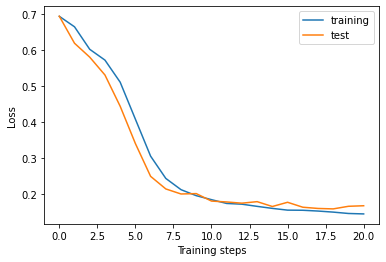

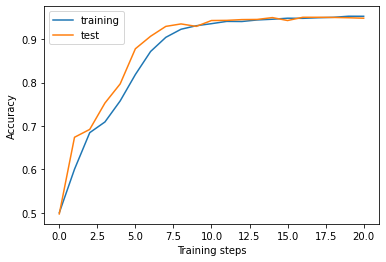

In [12]:
# Plot Figure displaying test and training loss for each epoch
plt.figure()
line1, = plt.plot(train_loss_list)
line2, = plt.plot(test_loss_list)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Plot Figure displaying test and training accuracy for each epoch
plt.figure()
line1, = plt.plot(train_accuracy_list)
line2, = plt.plot(test_accuracy_list)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()